In [33]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import importlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import csbdeep as cs
from csbdeep.utils import _raise, Path, axes_check_and_normalize,axes_dict, move_image_axes, move_channel_for_backend, backend_channels_last

%reload_ext autoreload
%autoreload 1
importlib.reload(cs)
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory

from csbdeep.models import Config, CARE

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [34]:
def load_alltraining_data(file, axes=None, n_images=None, verbose=False):
    """Load training data from file in ``.npz`` format.

    The data file is expected to have the keys:

    - ``X``    : Array of training input images.
    - ``Y``    : Array of corresponding target images.
    - ``axes`` : Axes of the training images.


    Parameters
    ----------
    file : str
        File name

    axes: str, optional
        Must be provided in case the loaded data does not contain ``axes`` information.
    n_images : int, optional
        Can be used to limit the number of images loaded from data.
    verbose : bool, optional
        Can be used to display information about the loaded images.

    Returns
    -------
    tuple( tuple(:class:`numpy.ndarray`, :class:`numpy.ndarray`), tuple(:class:`numpy.ndarray`, :class:`numpy.ndarray`), str )
        Returns two tuples (`X_train`, `Y_train`), (`X_val`, `Y_val`) of training and validation sets
        and the axes of the input images.
        The tuple of validation data will be ``None`` if ``validation_split = 0``.

    """

    f = np.load(file)
    X, Y = f['X'], f['Y']
    if axes is None:
        axes = f['axes']
    axes = axes_check_and_normalize(axes)

    assert X.shape == Y.shape
    assert len(axes) == X.ndim
    assert 'C' in axes
    if n_images is None:
        n_images = X.shape[0]
    assert X.shape[0] == Y.shape[0]
    assert 0 < n_images <= X.shape[0]

    X, Y = X[:n_images], Y[:n_images]
    channel = axes_dict(axes)['C']

 

    X = move_channel_for_backend(X,channel=channel)
    Y = move_channel_for_backend(Y,channel=channel)

    axes = axes.replace('C','') # remove channel
    if backend_channels_last():
        axes = axes+'C'
    else:
        axes = axes[:1]+'C'+axes[1:]

    data_val =  None

    if verbose:
        ax = axes_dict(axes)
        n_train = len(X)
        image_size = tuple( X.shape[ax[a]] for a in 'TZYX' if a in axes )
        n_dim = len(image_size)
        n_channel_in, n_channel_out = X.shape[ax['C']], Y.shape[ax['C']]

        print('number of training images:\t', n_train)
     
        print('image size (%dD):\t\t'%n_dim, image_size)
        print('axes:\t\t\t\t', axes)
        print('channels in / out:\t\t', n_channel_in, '/', n_channel_out)

    return (X,Y),  axes


In [35]:
(X,Y), axes = load_alltraining_data('/data/u934/service_imagerie/v_kapoor/StarDistTraining/UnetSegmentation.npz', verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
IMG_HEIGHT = X.shape[1]
IMG_WIDTH = X.shape[2]
IMG_CHANNELS = X.shape[c]
print(IMG_HEIGHT , IMG_WIDTH, IMG_CHANNELS )

number of training images:	 457728
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1
64 64 1


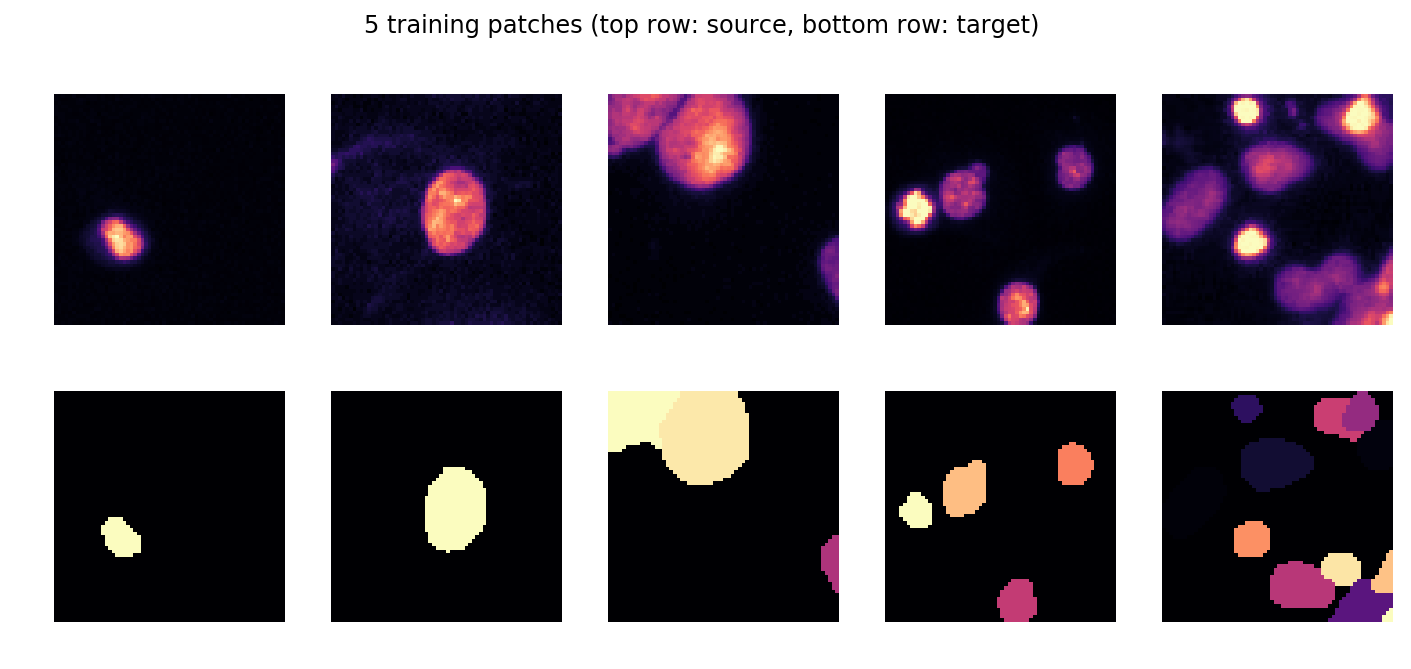

In [37]:
plt.figure(figsize=(12,5))
plot_some(X[:5],Y[:5])

plt.suptitle('5 training patches (top row: source, bottom row: target)');

In [38]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [39]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64, 64, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 8)    584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('models/UNet_model.h5', verbose=1, save_best_only=True)
results = model.fit(X, Y, validation_split=0.1, batch_size=8, epochs=1, 
                    callbacks=[earlystopper, checkpointer])

Train on 411955 samples, validate on 45773 samples
Epoch 1/1
 40840/411955 [=>............................] - ETA: 32:00 - loss: 0.1567 - mean_iou: 0.4923

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

In [ ]:
model.export_TF()